# CNN model

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

# Silence tensorflow, except for errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Run on the GTX1080 GPU - fastest single worker/small memory performance
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_project_root()

# Standard library imports
import pickle
import random
import time
from functools import partial
from pathlib import Path

# Third party imports
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import tensorflow as tf
from scipy.interpolate import griddata

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/model_training'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

# Make sure models directory exists
Path(config.MODELS_DIRECTORY).mkdir(parents=True, exist_ok=True)

# Best settings from ~400 Optuna optimization trials
# (see model_training/optimize_cnn.py)
sample_size = 817
learning_rate = 0.0005347916971873063
l_one = 0.0449757519123111
l_two = 0.04113331476112464
first_filter_set = 48
second_filter_set = 9
third_filter_set = 41
first_filter_size = 3
second_filter_size = 3
third_filter_size = 2
dense_units = 51
batch_size = 4
steps = 68

# Long training run
epochs = 1000

# Evaluation settings
samples = 10   # Number of samples to draw per planet
planets = 550  # Number of planets to evaluate

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Hyperparameter optimization results

### 1.1. Load Optuna study results

In [2]:
loaded_study = optuna.load_study(
    study_name='cnn_optimization',
    storage=f'postgresql://{config.USER}:{config.PASSWD}@{config.HOST}:{config.PORT}/{config.STUDY_NAME}'
)

results_df = loaded_study.trials_dataframe()
results_df = results_df[results_df['value'] < 0.02] # Filter out extreme high loss values
results_df.sort_values('value', ascending=True, inplace=True)

param_columns = [
    'params_batch_size', 'params_dense_units', 'params_first_filter_set',
    'params_first_filter_size', 'params_l_one', 'params_l_two',
    'params_learning_rate', 'params_sample_size', 'params_second_filter_set',
    'params_second_filter_size', 'params_steps', 'params_third_filter_set',
    'params_third_filter_size'
]

results_df.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_first_filter_set,params_first_filter_size,params_l_one,params_l_two,params_learning_rate,params_sample_size,params_second_filter_set,params_second_filter_size,params_steps,params_third_filter_set,params_third_filter_size,state
185,185,0.005324,2025-09-19 00:08:48.165462,2025-09-19 00:16:44.454979,0 days 00:07:56.289517,4,51,48,3,0.044976,0.041133,0.000535,817,9,3,68,41,2,COMPLETE
24,24,0.006007,2025-09-18 18:55:29.622361,2025-09-18 18:59:58.851405,0 days 00:04:29.229044,4,40,58,3,0.050448,0.066101,0.000782,715,25,3,97,40,2,COMPLETE
197,197,0.006070,2025-09-19 00:31:38.045500,2025-09-19 00:36:43.265829,0 days 00:05:05.220329,4,42,47,3,0.041697,0.035889,0.001335,832,29,3,98,41,2,COMPLETE
16,16,0.006080,2025-09-18 18:41:43.385676,2025-09-18 18:54:11.125940,0 days 00:12:27.740264,4,44,50,3,0.050003,0.058902,0.000571,822,23,3,100,41,2,COMPLETE
124,124,0.006318,2025-09-18 22:17:54.248410,2025-09-18 22:35:22.350598,0 days 00:17:28.102188,4,19,49,6,0.044836,0.067788,0.000307,840,31,3,93,41,2,COMPLETE


In [3]:
results_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
number,394.0,197.279188,0.0,99.25,197.5,295.75,395.0,114.20139
value,394.0,0.014022,0.005324,0.011976,0.013735,0.016354,0.018761,0.003019
datetime_start,394,2025-09-19 00:41:18.457740288,2025-09-18 18:29:28.455370,2025-09-18 21:40:05.845310720,2025-09-19 00:31:48.983830016,2025-09-19 03:39:30.091732224,2025-09-19 07:38:14.248156,NaN
datetime_complete,394,2025-09-19 00:49:21.558501888,2025-09-18 18:30:03.652386,2025-09-18 21:45:23.136469248,2025-09-19 00:37:39.648955392,2025-09-19 03:49:34.323184384,2025-09-19 07:48:37.266349,NaN
duration,394,0 days 00:08:03.100761520,0 days 00:00:32.000197,0 days 00:03:11.866434500,0 days 00:05:05.541335,0 days 00:09:33.391098750,0 days 01:02:33.387428,0 days 00:07:59.067460578
params_batch_size,394.0,4.753807,1.0,4.0,4.0,4.0,16.0,3.145787
params_dense_units,394.0,35.901015,1.0,23.0,40.0,44.0,63.0,12.246944
params_first_filter_set,394.0,49.200508,1.0,47.0,49.5,55.0,64.0,10.098643
params_first_filter_size,394.0,3.77665,2.0,3.0,3.0,5.0,6.0,1.323448
params_l_one,394.0,0.048755,0.002201,0.042731,0.04749,0.053493,0.099535,0.012973


### 1.2. Validation loss distribution

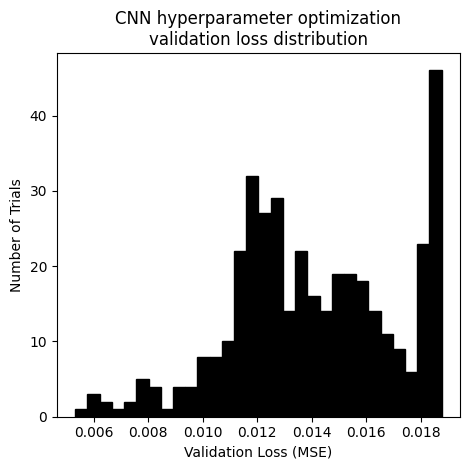

In [4]:
plt.figure(figsize=(config.STD_FIG_WIDTH/1.25, config.STD_FIG_WIDTH/1.25))
plt.title('CNN hyperparameter optimization\nvalidation loss distribution')
plt.hist(
    results_df['value'],
    bins=30,
    color='black',
    edgecolor='black'
)
plt.xlabel('Validation Loss (MSE)')
plt.ylabel('Number of Trials')
# plt.yscale('log')
plt.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/03.1.1-validation_loss_distribution.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)


### 1.3. Hyperparameter sampling distributions

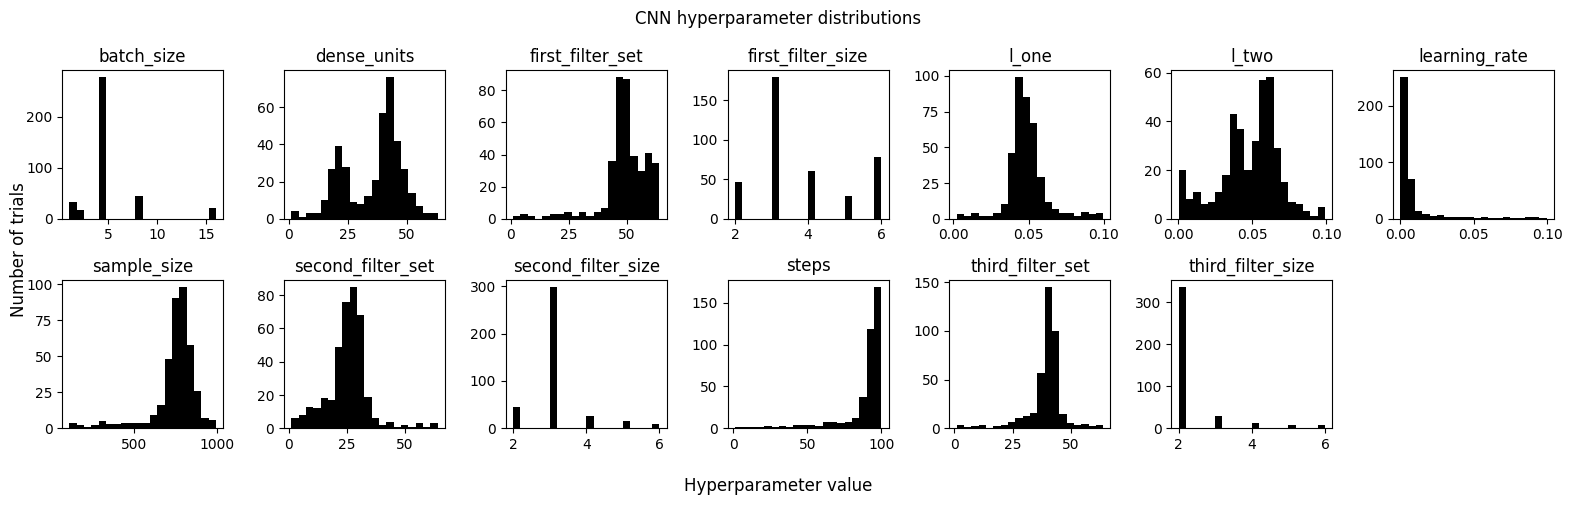

In [5]:
fig, axs = plt.subplots(2, 7, figsize=(16, 5))
axs = axs.flatten()

fig.suptitle('CNN hyperparameter distributions')
fig.supxlabel('Hyperparameter value')
fig.supylabel('Number of trials')

for i, param in enumerate(param_columns):
    axs[i].set_title(param.replace('params_', ''))
    axs[i].hist(
        results_df[param],
        bins=20,
        color='black'
    )

axs[-1].axis('off')  # Turn off the last unused subplot

fig.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/03.1.2-hyperparameter_distributions.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

### 1.4. Hyperparameter heatmap matrix

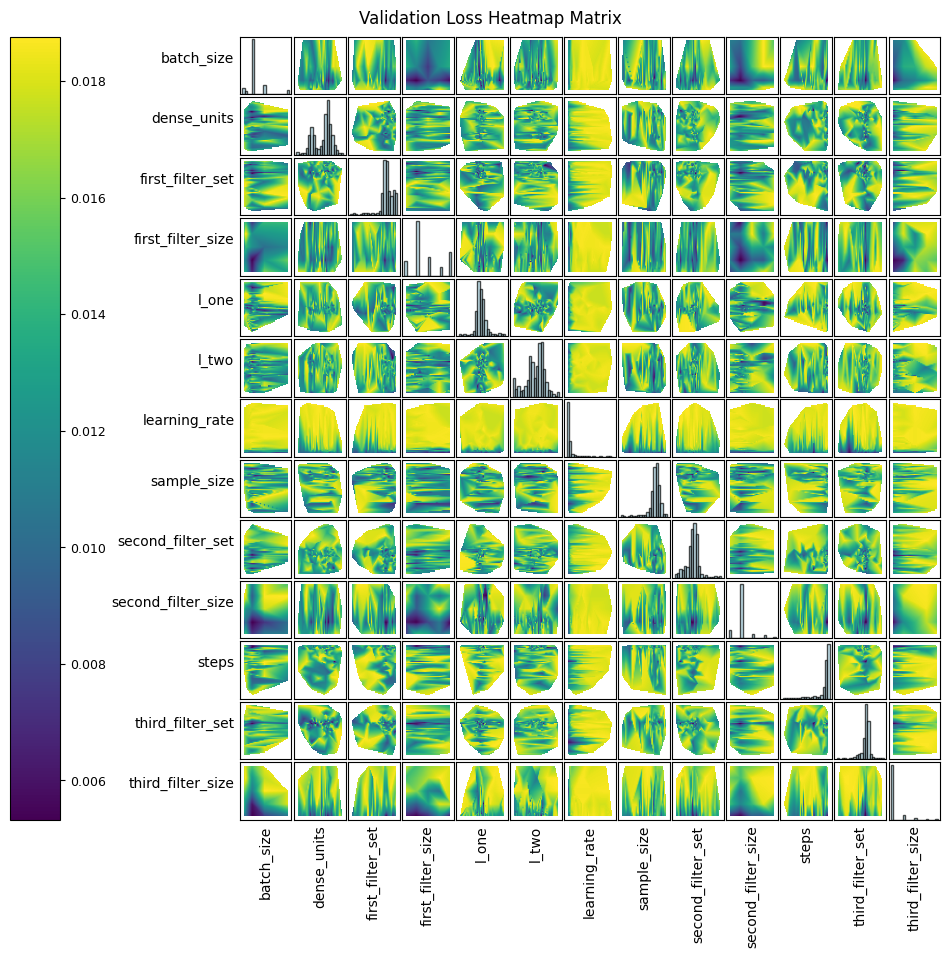

In [6]:
# Create a figure with subplots for the heatmap matrix
n_params = len(param_columns)
fig, axes = plt.subplots(n_params, n_params, figsize=(10, 9))

# Get the range of validation loss values for consistent color scaling
vmin, vmax = results_df['value'].min(), results_df['value'].max()

# Create the heatmap matrix
for i, param_y in enumerate(param_columns):
    for j, param_x in enumerate(param_columns):
        ax = axes[i, j]
        
        if i == j:

            # For diagonal elements, show parameter distribution as histogram
            ax.hist(
                results_df[param_x],
                bins=20,
                alpha=0.7,
                color='lightblue',
                edgecolor='black'
            )
            
            # Configure tick labels and marks: only show for bottom row (x) and first column (y)
            if j == 0:  # Left edge
                ax.set_ylabel(param_y.replace('params_', ''), rotation='horizontal', ha='right')

            if i == n_params - 1:  # Bottom edge
                ax.set_xlabel(param_x.replace('params_', ''), rotation='vertical')

            # Hide all tick labels and marks
            ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, top=False, right=False)

        else:
            # Create interpolated heatmap of validation loss
            x_data = results_df[param_x].values
            y_data = results_df[param_y].values
            z_data = results_df['value'].values
            
            # Create a regular grid for interpolation
            x_min, x_max = x_data.min(), x_data.max()
            y_min, y_max = y_data.min(), y_data.max()
            
            # Add small margins to avoid edge effects
            x_margin = (x_max - x_min) * 0.05
            y_margin = (y_max - y_min) * 0.05
            
            x_grid = np.linspace(x_min - x_margin, x_max + x_margin, 50)
            y_grid = np.linspace(y_min - y_margin, y_max + y_margin, 50)
            X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
            
            # Interpolate using griddata
            Z_interp = griddata(
                (x_data, y_data), z_data, (X_grid, Y_grid), 
                method='linear', fill_value=np.nan
            )
            
            # Standardize the heatmap using its own min/max values
            z_min_local = np.nanmin(Z_interp)
            z_max_local = np.nanmax(Z_interp)
            
            # Create the interpolated heatmap with individual scaling
            im = ax.imshow(Z_interp, origin='lower', aspect='auto', 
                cmap='viridis', vmin=z_min_local, vmax=z_max_local,
            )
            
            # Set labels only for edge subplots to avoid clutter
            if j == 0:  # Left edge
                ax.set_ylabel(param_y.replace('params_', ''), rotation='horizontal', ha='right')

            if i == n_params - 1:  # Bottom edge
                ax.set_xlabel(param_x.replace('params_', ''), rotation='vertical')

            # Hide all tick labels and marks
            ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, top=False, right=False)

# Add a single colorbar to the left of the figure showing the global range
# Note: Individual heatmaps are standardized to their own ranges
cbar_ax = fig.add_axes([0.02, 0.08, 0.05, 0.87])  # [left, bottom, width, height]

# Create a dummy mappable for the global colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=9)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.08, hspace=0.05, wspace=0.05)

# Add a main title
fig.suptitle(
    'Validation Loss Heatmap Matrix'
)

# Save the figure
plt.savefig(
    f'{figures_dir}/03.1.3-hyperparameter_validation_loss_heatmaps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

## 2. Long training run

### 2.1. Data preparation 

#### 2.1.1. Load planet list

In [7]:
# Load corrected/extracted data for a sample planet
with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    planet_ids = list(hdf.keys())

print(f'Found {len(planet_ids)} planets in training data.')

Found 1100 planets in training data.


#### 2.1.2. Split planets into training & validation

In [8]:
planet_ids_file = f'{config.METADATA_DIRECTORY}/planet_ids.pkl'

if Path(planet_ids_file).exists():

    with open(planet_ids_file, 'rb') as input_file:
        planet_ids = pickle.load(input_file)
        training_planet_ids = planet_ids['training']
        validation_planet_ids = planet_ids['validation']

    print('Loaded existing training/validation split')

else:
    
    print('Creating new training/validation split')

    random.shuffle(planet_ids)
    training_planet_ids = planet_ids[:len(planet_ids) // 2]
    validation_planet_ids = planet_ids[len(planet_ids) // 2:]

    # Save the training and validation planet IDs
    planet_ids = {
        'training': training_planet_ids,
        'validation': validation_planet_ids
    }

    with open(planet_ids_file, 'wb') as output_file:
        pickle.dump(planet_ids, output_file)

print(f'Training planets: {len(training_planet_ids)}')
print(f'Validation planets: {len(validation_planet_ids)}')

Loaded existing training/validation split
Training planets: 550
Validation planets: 550


### 2.2. Data generator

#### 2.2.1. Data loader function

In [9]:
def data_loader(planet_ids: list, data_file: str, sample_size: int = 100):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            np.random.shuffle(planet_ids)
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]
                spectrum = hdf[planet_id]['spectrum'][:]

                indices = random.sample(range(signal.shape[0]), sample_size)
                sample = signal[sorted(indices), :]

                yield sample, spectrum


#### 2.2.2. Prefill the arguments to `data_loader()`

In [10]:
training_data_generator = partial(
    data_loader,
    planet_ids=training_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size
)

validation_data_generator = partial(
    data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size
)

#### 2.2.3. Create TF datasets

In [11]:
training_dataset = tf.data.Dataset.from_generator(
    training_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(config.WAVELENGTHS), dtype=tf.float64)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    validation_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(config.WAVELENGTHS), dtype=tf.float64)
    )
)

### 2.3. CNN

#### 2.3.1. Model definition

In [12]:
def compile_model(
        samples: int=sample_size,
        wavelengths: int=config.WAVELENGTHS,
        learning_rate: float=learning_rate,
        l1: float=l_one,
        l2: float=l_two,
        filter_nums=[first_filter_set, second_filter_set, third_filter_set],
        filter_sizes=[first_filter_size, second_filter_size, third_filter_size]
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((samples,wavelengths,1)),
        tf.keras.layers.Conv2D(
            filter_nums[0],
            filter_sizes[0],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[1],
            filter_sizes[1],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[2],
            filter_sizes[2],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            dense_units,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='relu')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra
    # metrics to evaluate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )

    return model

In [13]:
model = compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 817, 283, 48)      480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 408, 141, 48)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 408, 141, 9)       3897      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 204, 70, 9)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 204, 70, 41)       1517      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 102, 35, 41)      0

#### 2.3.2. Training

In [14]:
total_ksteps = int((epochs * steps) / 1000)
model_save_file = f'{config.MODELS_DIRECTORY}/optimized_cnn-{total_ksteps}ksteps.keras'
training_results_save_file = f'{config.MODELS_DIRECTORY}/training_results-{total_ksteps}ksteps.pkl'

if Path(model_save_file).exists() and Path(training_results_save_file).exists():

    print(f'Found existing model for {total_ksteps} ksteps, skipping training.')

    # Load the existing model
    model = tf.keras.models.load_model(model_save_file)

    # Load existing training results
    with open(training_results_save_file, 'rb') as input_file:
        training_results = pickle.load(input_file)

else:

  print(f'Training model for {total_ksteps} ksteps')
  start_time = time.time()

  training_results = model.fit(
    training_dataset.batch(batch_size),
    validation_data=validation_dataset.batch(batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=steps,
    verbose=0
  )

  print(f'Training complete in {(time.time() - start_time)/60:.1f} minutes')
  model.save(model_save_file)

  with open(training_results_save_file, 'wb') as output_file:
      pickle.dump(training_results, output_file)

Training model for 68 ksteps
Training complete in 62.3 minutes
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......root_mean_squared_error
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name 

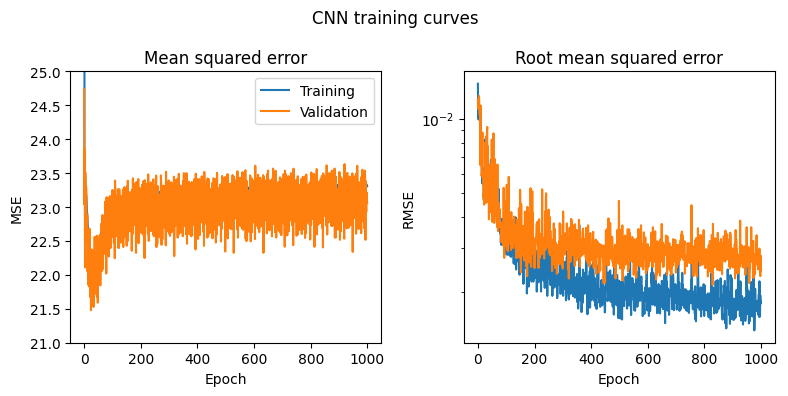

In [24]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation MSE
axs[0].set_title('Mean squared error')
axs[0].plot(np.array(training_results.history['loss']), label='Training')
axs[0].plot(np.array(training_results.history['val_loss']), label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[0].set_ylim(21, 25)
# axs[0].set_yscale('log')
axs[0].legend(loc='upper right')

# Plot training and validation RMSE
axs[1].set_title('Root mean squared error')
axs[1].plot(training_results.history['RMSE'])
axs[1].plot(training_results.history['val_RMSE'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('RMSE')
# axs[1].set_ylim(top=0.014)
axs[1].set_yscale('log')

# Show the plot
fig.tight_layout()
fig.savefig(
    f'{figures_dir}/03.1.4-training_curves_{total_ksteps}ksteps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 3. Model evaluation (validation set)

### 3.1. Prediction dataset

In [16]:
def prediction_data_loader(planet_ids: list, data_file: str, sample_size: int = 100, n_samples: int = 10):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]

                samples = []
                spectra = []

                for _ in range(n_samples):

                    indices = random.sample(range(signal.shape[0]), sample_size)
                    samples.append(signal[sorted(indices), :])
                    spectra.append(hdf[planet_id]['spectrum'][:])

                yield np.array(samples), np.array(spectra)


In [17]:
prediction_data_generator = partial(
    prediction_data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size,
    n_samples=samples
)

In [18]:
prediction_dataset = tf.data.Dataset.from_generator(
    prediction_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(samples, sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(samples, config.WAVELENGTHS), dtype=tf.float64)
    )
)

In [19]:
validation_data = prediction_dataset.take(planets)

signals = np.array([element[0].numpy() for element in validation_data])
spectra = np.array([element[1].numpy() for element in validation_data])

print(f'Signals shape: {signals.shape}')
print(f'Spectra shape: {spectra.shape}')

Signals shape: (550, 10, 817, 283)
Spectra shape: (550, 10, 283)


### 3.2. Predictions

In [20]:
spectrum_predictions = []

for planet in signals:
    spectrum_predictions.append(model.predict(planet, batch_size=samples, verbose=0))

spectrum_predictions = np.array(spectrum_predictions)
spectrum_predictions_avg = np.mean(spectrum_predictions, axis=1).flatten()
spectrum_predictions = spectrum_predictions.flatten()
reference_spectra = spectra[:,0,:].flatten()
spectra = spectra.flatten()

### 3.3. Plot

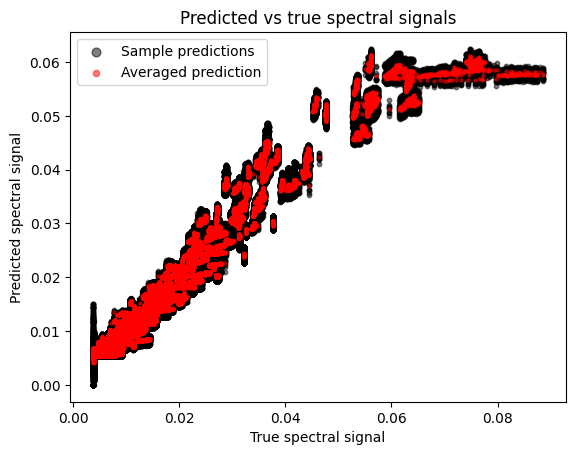

In [21]:
plt.title('Predicted vs true spectral signals')
plt.scatter(spectra, spectrum_predictions, s=10, alpha=0.5, color='black', label='Sample predictions')
plt.scatter(reference_spectra, spectrum_predictions_avg, s=5, alpha=0.5, color='red', label='Averaged prediction')
plt.xlabel('True spectral signal')
plt.ylabel('Predicted spectral signal')
plt.legend(loc='best', markerscale=2)

plt.savefig(
    f'{figures_dir}/03.1.5-predicted_vs_true_spectra.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()
